In [1]:
import tensorflow as tf
import tensorflow_io as tfio
import keras
from keras import layers
from keras.layers import Dense, Flatten, Conv2D
from keras.models import Sequential, load_model
from sklearn.model_selection import train_test_split
import numpy as np
import pathlib
import os
from IPython import display
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd

In [2]:
datapath = os.path.join('Data', 'WakeWord', 'Homebot')

In [3]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [4]:
POS = os.path.join('Data', 'WakeWord', 'Homebot')
NEG = os.path.join('Data', 'WakeWord', 'Other')

In [5]:
pos = tf.data.Dataset.list_files(POS +'/*.wav')
neg = tf.data.Dataset.list_files(NEG +'/*.wav')

In [6]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
                                
data = positives.concatenate(negatives)

In [7]:
lengths = []
for file in os.listdir(os.path.join('Data', 'WakeWord', 'Homebot')):
    tensor_wave = load_wav(os.path.join('Data', 'WakeWord', 'Homebot', file))
    lengths.append(len(tensor_wave))

In [8]:
tf.math.reduce_mean(lengths)
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=47925>

In [9]:
def preprocess(file_path, label):
    wav = load_wav(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

b'Data\\WakeWord\\Homebot\\HOMEBOT42.wav'


<function matplotlib.pyplot.show(close=None, block=None)>

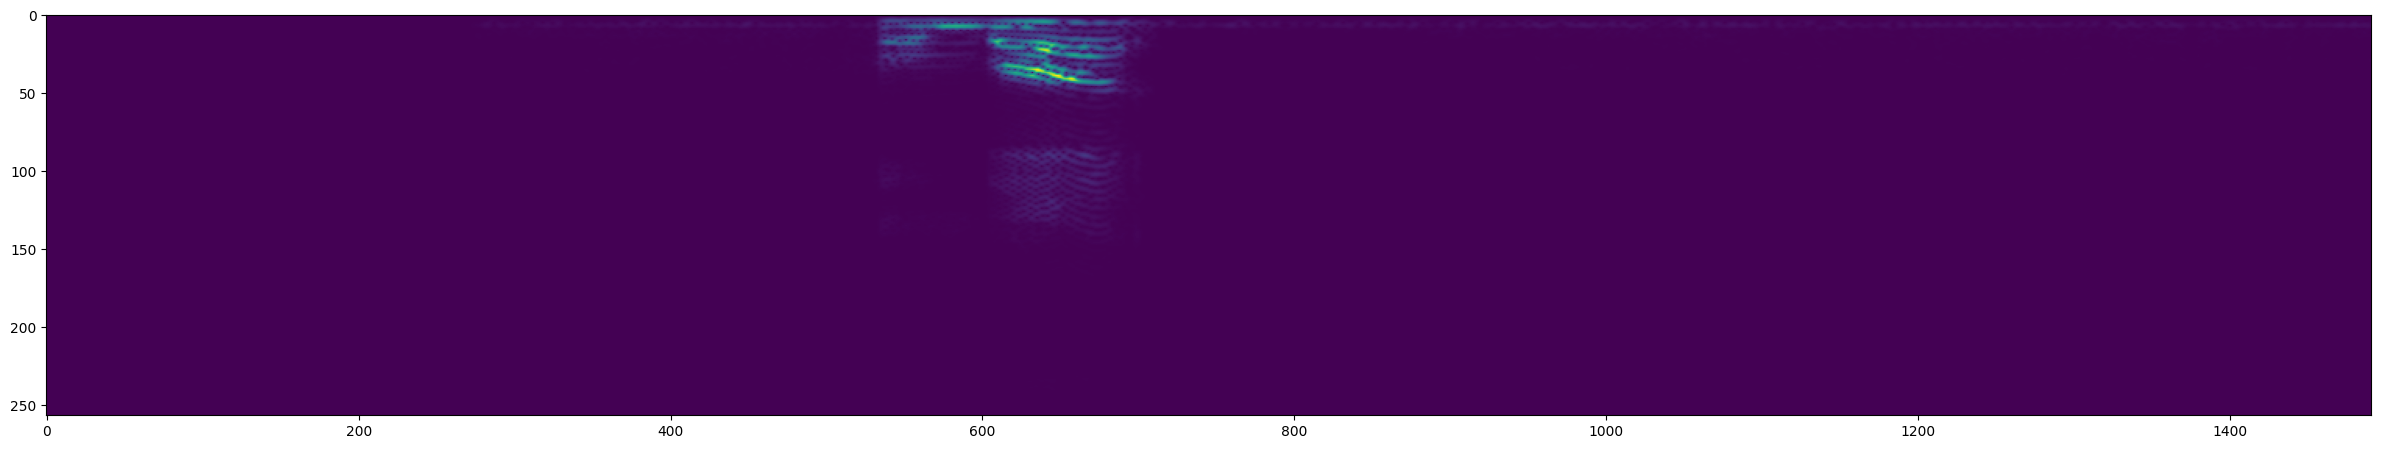

In [10]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(filepath)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show

In [11]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(8)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [12]:
train = data.take(8)
test = data.skip(8).take(1)

In [13]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(8, 1491, 257, 1)

In [14]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()], run_eagerly=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(train, batch_size=8, epochs=10,validation_data=test)

Epoch 1/10
8/8 [==============================] - 79s 10s/step - loss: 0.3632 - recall: 0.8485 - precision: 0.9032 - val_loss: 0.0225 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/10
8/8 [==============================] - 74s 9s/step - loss: 0.3048 - recall: 0.9459 - precision: 1.0000 - val_loss: 0.0268 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/10
8/8 [==============================] - 74s 9s/step - loss: 0.0222 - recall: 1.0000 - precision: 0.9737 - val_loss: 0.0014 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
8/8 [==============================] - 74s 9s/step - loss: 0.0011 - recall: 1.0000 - precision: 1.0000 - val_loss: 5.0776e-05 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 5/10
8/8 [==============================] - 74s 9s/step - loss: 0.0054 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.4775 - val_recall: 1.0000 - val_precision: 0.8750
Epoch 6/10
8/8 [==============================] - 73s 9s/step - loss: 0.1341 - recall: 1.0000 - precision

In [17]:
model.save("processor.h5")

In [18]:
preds = model.predict(train)
preds

8/8 [==============================] - 3s 435ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [5.9907768e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.9983716e-16],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.5534008e-17],
       [5.8210533e-17],
       [1.0000000e+00],
       [1.2091129e-17],
       [2.4858648e-17],
       [1.2534241e-16],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.1554575e-16],
       [4.2637475e-17],
       [4.1955633e-17],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [3.7884386e-17],
       [3.0536911e-17],
       [1.0000000e+00],
       [6.2354343e-18],
       [2.1339619e-15],
       [1.0000000e+00],
       [3.0181551e-13],
       [5.2800529e-16],
       [1.000000